# 熱源機器特性のグラフ表示

- 非住宅一次エネルギー消費量計算プログラムで使用している空調熱源機器特性をグラフで表示します。

## A. ファイル読み込み
- 熱源機器特性を規定している\REFLIST_H28.csv, \REFCURVE_H28.csv から読み込み
  - このプログラムファイルと同パスに上記2ファイルを置くこと
  - 上記2ファイルを含むzipファイルのURL：http://www.kenken.go.jp/becc/documents/building/Definitions/REFLIST_H28_REFCURVE_H28 (2019/8現在)

In [1]:
""" ファイルから読み込み """
import pandas as pd
import sys

def input_files(filename):
    # filename: '\REFLIST_H28.csv' or '\REFCURVE_H28.csv'
    dat = pd.read_csv("."+filename, encoding="ms932", sep=",").values.tolist()
    return dat

In [2]:
""" input_files - Test """
reflist  = input_files('\REFLIST_H28.csv')
print(reflist)
refcurve  = input_files('\REFCURVE_H28.csv')
print(refcurve)

[['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '能力比', 25.0, 40.0, 'Cq_AS_A', 0.95, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '入力比', 25.0, 40.0, 'Cp_AS_A', 1.2, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '部分負荷特性', 0.1, 1.0, 'Cx_AS_A', 1.0, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '送水温度特性', 5.0, 15.0, 'Cw_AS_A', 1.0, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Heating', '能力比', -15.0, -8.0, 'Hq_AS_A1', 0.95, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Heating', '能力比', -8.0, 4.5, 'Hq_AS_A2', 0.95, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Heating', '能力比', 4.5, 15.5, 'Hq_AS_A3', 0.95, nan, nan], ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Heating', '入力比', -15.0, 15.5, 'Hp_AS_A', 1.2, nan, nan], ['WaterChilli

## B. 熱源機器特性データの格納
- 熱源機器特性データを多層の辞書として格納

- `ch_hse`: [機種][冷／暖][特性種類][下限][冷却水温度下限]の多段のキーの値として、\REFLIST_H28.csv のデータ＋対応する \REFCURVE_H28.csvの特性パラメータ をリストとして持つ

 - [名称, 機種, 燃料種類, 熱源種類, 冷房／暖房, 特性種類, 下限, 上限, 特性ID, 基整促係数, 冷却水温度下限, 冷却水温度上限, \REFLIST_H28.csvのリストの並び順, \REFCURVE_H28.csvの特性パラメータのリスト]
 - \REFCURVE_H28.csvの特性パラメータのリストは、[名称(番号), 名称(特性ID), 説明, x4, x3, x2, x1, a, 特性曲線リストの順番]
 - 温度下限の設定がない場合は-99℃で置き換え。上限は999℃で置き換え。

In [3]:
""" 熱源機器特性データの格納 """
def set_data(file01, file02):   # file01: '\REFLIST_H28.csv', file02: '\REFCURVE_H28.csv'
    
    reflist  = input_files(file01)
    refcurve = input_files(file02)
   
    dic_curve = {}
    for i in range(len(refcurve)):
        dic_curve0 = refcurve[i]
        dic_curve0.append(i)
        dic_curve[dic_curve0[1]] = dic_curve0 
        # dic_curve[key] = refcurve[i]のリストの最後に順番iをチェック用に付加したリスト
        # key=refcurve[i][1]: 特性曲線の名称(ex.Cq_AS_A)
        # l=0:名称, l=1:名称, l=2:説明, l=3:x4, l=4:x3, l=5:x2, l=6:x1, l=7:a, l=8:特性曲線リストの順番

    ch_hse = {}
    for i in range(len(reflist)):
        ch_hse0 = reflist[i]
        ch_hse0.append(i)
        ch_hse0.append(dic_curve[ch_hse0[8]])
        # ch_hse0[k]: reflist[i]のリストの最後に順番i(チェック用)と該当する特性曲線のパラメータ
        #             リストを付加したリスト
        # k=0:名称, k=1:機種, k=2:燃料種類, k=3:熱源種類, k=4:冷房／暖房,
        # k=5:特性種類, k=6:下限, k=7:上限, k=8:特性ID, k=9:基整促係数,
        # k=10:冷却水温度下限, k=11:冷却水温度上限, k=12:リストの順番
        # k=13:特性IDで紐付けされている特性曲線パラメータリスト

        ch_hse.setdefault(ch_hse0[1], {})
        ch_hse[ch_hse0[1]].setdefault(ch_hse0[4], {})
        ch_hse[ch_hse0[1]][ch_hse0[4]].setdefault(ch_hse0[5], {})
        if ch_hse0[10]!=ch_hse0[10]:
            ch_hse0[10] = -99.0       # 冷却水温度下限がNaNの場合 → -99℃を挿入
        if ch_hse0[11]!=ch_hse0[11]:  # 冷却水温度上限がNaNの場合 → 999℃を挿入
            ch_hse0[11] = 999.0    
        ch_hse[ch_hse0[1]][ch_hse0[4]][ch_hse0[5]].setdefault(ch_hse0[10], {})
        if ch_hse0[6]!=ch_hse0[6]:    # 下限がNaNの場合 → -99℃を挿入
            ch_hse0[6] = -99.0
        if ch_hse0[7]!=ch_hse0[7]:    # 上限がNaNの場合 → 999℃を挿入
            ch_hse0[6] = 999.0
        ch_hse[ch_hse0[1]][ch_hse0[4]][ch_hse0[5]][ch_hse0[10]].setdefault(ch_hse0[6], {})            
        ch_hse[ch_hse0[1]][ch_hse0[4]][ch_hse0[5]][ch_hse0[10]][ch_hse0[6]] = ch_hse0      
        # ch_hse[機種][冷／暖][特性種類][冷却水温度下限][下限][k]
   
    return ch_hse

In [4]:
""" set_data - Test """
file01='\REFLIST_H28.csv'
file02='\REFCURVE_H28.csv'
ch_hse = set_data(file01, file02)
print (ch_hse)

print(ch_hse.keys())

print (ch_hse['インバータターボ冷凍機'])

{'ウォータチリングユニット(空冷式)': {'Cooling': {'能力比': {-99.0: {25.0: ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '能力比', 25.0, 40.0, 'Cq_AS_A', 0.95, -99.0, 999.0, 0, [1.0, 'Cq_AS_A', '能力比特性（冷）', 0.0, 0.0, 0.0, -0.0091, 1.3185, 0]]}}, '入力比': {-99.0: {25.0: ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '入力比', 25.0, 40.0, 'Cp_AS_A', 1.2, -99.0, 999.0, 1, [5.0, 'Cp_AS_A', '入力比特性（冷）', 0.0, 0.0, 0.000296, 0.0004, 0.6234, 8]]}}, '部分負荷特性': {-99.0: {0.1: ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '部分負荷特性', 0.1, 1.0, 'Cx_AS_A', 1.0, -99.0, 999.0, 2, [12.0, 'Cx_AS_A', '部分負荷特性（冷）', 0.0, 0.0, 0.3344, 0.4707, 0.1949, 19]]}}, '送水温度特性': {-99.0: {5.0: ['WaterChillingUnit_AirSource', 'ウォータチリングユニット(空冷式)', '電力', '空気', 'Cooling', '送水温度特性', 5.0, 15.0, 'Cw_AS_A', 1.0, -99.0, 999.0, 3, [26.0, 'Cw_AS_A', '送水温度特性（冷）', 0.0, 0.0, 0.0, 0.0, 1.0, 36]]}}}, 'Heating': {'能力比': {-99.0: {-15.0: ['WaterChillingUnit_AirSource', 'ウォータチリングユニッ

## C.グラフ描画

In [5]:
""" 性能曲線の4次式計算 """
def func004(coeff, x):
    func = coeff[4]
    for i in range(4):
        func += coeff[i] * x**(4-i)
    return func   

In [6]:
""" グラフ描画用関数 """
import numpy as np

def func_ch(coeff1, x):
    coeff1keys = sorted(list(coeff1.keys()))    # 下限のリストをソート
    y0 = []
    for xx in x:
        for ikey in coeff1keys:
            if coeff1[ikey][0]  <= xx < coeff1[ikey][1]:
                yy = func004(coeff1[ikey][2:7], xx)
                y0.append(yy)
    y = np.array(y0)
    return y   

In [7]:
""" func_ch - Test """

coeff1={-99: [-99, -15.0, 0, 0, 0, 0, 0.4645], -15.0: [-15.0, -8.0, 0.0, 0.0, 0.0, 0.0255, 0.847], -8.0: [-8.0, 4.5, 0.0, 0.0, 0.0, 0.0153, 0.762], 4.5: [4.5, 15.5, 0.0, 0.0, 0.0, 0.0255, 0.847], 15.5: [15.5, 999, 0, 0, 0, 0, 1.2422499999999999]}
x = np.arange(-20, 21, 1)
y=func_ch(coeff1, x)
print(x)
print(y)

[-20 -19 -18 -17 -16 -15 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3
  -2  -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15
  16  17  18  19  20]
[0.4645  0.4645  0.4645  0.4645  0.4645  0.4645  0.49    0.5155  0.541
 0.5665  0.592   0.6175  0.6396  0.6549  0.6702  0.6855  0.7008  0.7161
 0.7314  0.7467  0.762   0.7773  0.7926  0.8079  0.8232  0.9745  1.
 1.0255  1.051   1.0765  1.102   1.1275  1.153   1.1785  1.204   1.2295
 1.24225 1.24225 1.24225 1.24225 1.24225]


In [8]:
""" グラフ描画データの抽出・整理 """
def func_check(ch_hse, HSE_name, CorH, Cha0):

    if HSE_name in ch_hse:
        if CorH in ch_hse[HSE_name]:
            if Cha0 in ch_hse[HSE_name][CorH]:
                coeff0 = {}
                for ikey in ch_hse[HSE_name][CorH][Cha0].keys():
                    coeff1 = {}
                    jn=len(ch_hse[HSE_name][CorH][Cha0][ikey].keys())
                    xmin = [-99,999,0,0,0,0,0]
                    xmax = [-99,999,0,0,0,0,0]
                    coeff1[-99] = [-99,999,0,0,0,0,0]
                    
                    # 下限～上限の特性曲線の係数値が設定されている部分のデータ整理
                    for jkey in ch_hse[HSE_name][CorH][Cha0][ikey].keys():
                        if xmin[1] > ch_hse[HSE_name][CorH][Cha0][ikey][jkey][6]:
                            xmin[1] = ch_hse[HSE_name][CorH][Cha0][ikey][jkey][6]
                            xmin[2:7]=ch_hse[HSE_name][CorH][Cha0][ikey][jkey][13][3:8]
                        if xmax[0] < ch_hse[HSE_name][CorH][Cha0][ikey][jkey][7]:
                            xmax[0] = ch_hse[HSE_name][CorH][Cha0][ikey][jkey][7]
                            xmax[2:7]=ch_hse[HSE_name][CorH][Cha0][ikey][jkey][13][3:8]                    
                        coeff2 = [ch_hse[HSE_name][CorH][Cha0][ikey][jkey][6]]
                        coeff2 += [ch_hse[HSE_name][CorH][Cha0][ikey][jkey][7]]
                        coeff2 += ch_hse[HSE_name][CorH][Cha0][ikey][jkey][13][3:8]
                        coeff1[jkey] = coeff2
                        
                    # 下限以下、上限以上で一定値を取る部分のデータ整理
                    xmin[6] = func004(xmin[2:7], xmin[1])
                    xmax[6] = func004(xmax[2:7], xmax[0])
                    for k in range(2,6):
                        xmin[k] = 0
                        xmax[k] = 0
                        
                    coeff1[xmin[0]] = xmin                    
                    coeff1[xmax[0]] = xmax
                    coeff0[ikey] = coeff1
    return coeff0

In [9]:
""" func_check - Test """
file01='\REFLIST_H28.csv'
file02='\REFCURVE_H28.csv'
HSE_name='ウォータチリングユニット(空冷式)'
CorH='Heating'
Cha0='能力比'
ch_hse = set_data(file01, file02)
coeff0=func_check(ch_hse, HSE_name, CorH, Cha0)
print(coeff0)

HSE_name='ウォータチリングユニット(空冷式モジュール形)'
CorH='Cooling'
Cha0='部分負荷特性'
ch_hse = set_data(file01, file02)
coeff0=func_check(ch_hse, HSE_name, CorH, Cha0)
print(coeff0)

HSE_name='インバータターボ冷凍機'
CorH='Cooling'
Cha0='部分負荷特性'
ch_hse = set_data(file01, file02)
coeff0=func_check(ch_hse, HSE_name, CorH, Cha0)
print(coeff0)

{-99.0: {-99: [-99, -15.0, 0, 0, 0, 0, 0.4645], -15.0: [-15.0, -8.0, 0.0, 0.0, 0.0, 0.0255, 0.847], -8.0: [-8.0, 4.5, 0.0, 0.0, 0.0, 0.0153, 0.762], 4.5: [4.5, 15.5, 0.0, 0.0, 0.0, 0.0255, 0.847], 15.5: [15.5, 999, 0, 0, 0, 0, 1.2422499999999999]}}
{-99.0: {-99: [-99, 0.1, 0, 0, 0, 0, 0.137206], 0.1: [0.1, 1.0, 0.0, 0.0, 0.1726, 0.7688, 0.0586], 1.0: [1.0, 999, 0, 0, 0, 0, 1.0]}}
{0.0: {-99: [-99, 0.2, 0, 0, 0, 0, 0.2399626708], 0.2: [0.2, 1.0, 0.0, 0.0, 0.58656667, 0.24616667, 0.16726667], 1.0: [1.0, 999, 0, 0, 0, 0, 1.00000001]}, 24.0: {-99: [-99, 0.2, 0, 0, 0, 0, 0.321936], 0.2: [0.2, 1.0, 0.0, 0.0, 0.4759, 0.2765, 0.2476], 1.0: [1.0, 999, 0, 0, 0, 0, 1.0]}, 32.0: {-99: [-99, 0.2, 0, 0, 0, 0, 0.36465813736], 0.2: [0.2, 1.0, 0.0, 0.21876667, 0.0032, 0.51906667, 0.25896667], 1.0: [1.0, 999, 0, 0, 0, 0, 1.00000001]}}


Dropdown(description='熱源機の種類:', index=1, layout=Layout(width='500px'), options=('機種を選んでください', 'ウォータチリングユニット(空冷…

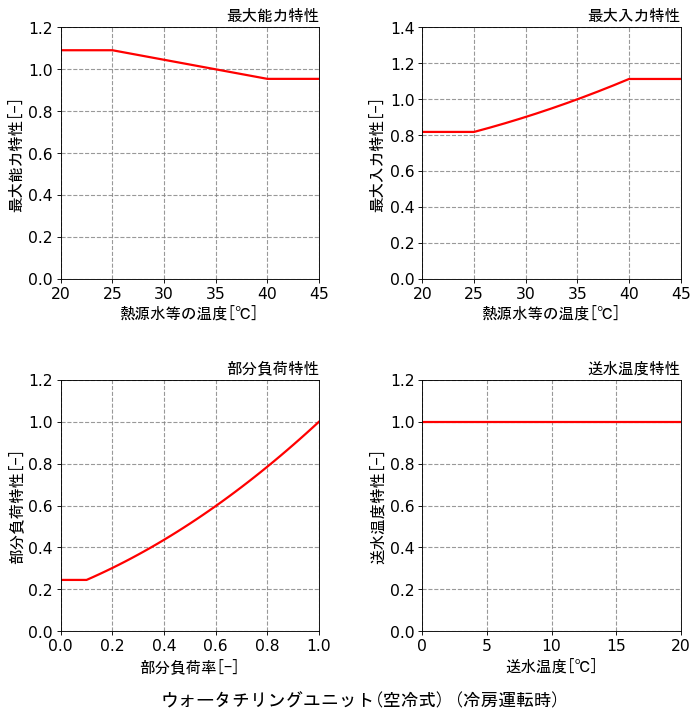

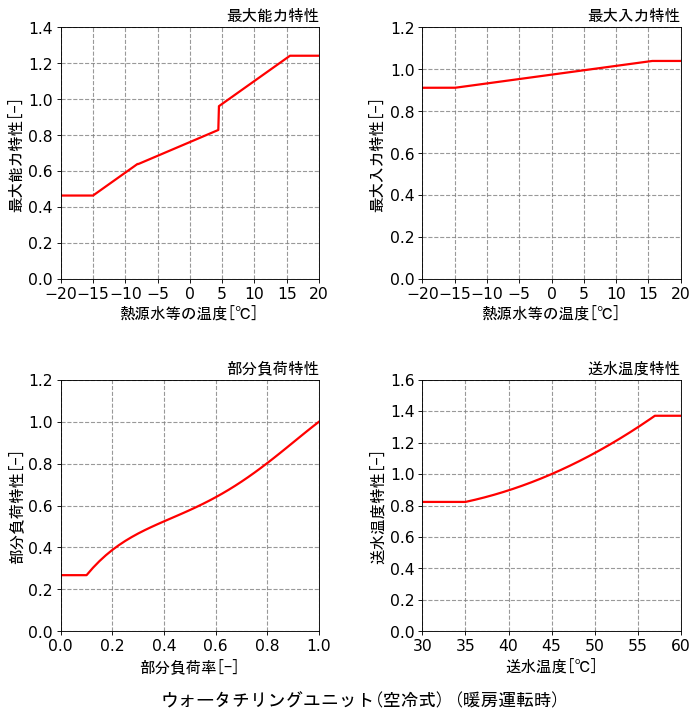

In [10]:
import platform
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages 
import ipywidgets as widgets
from IPython.display import display, clear_output
%matplotlib inline

# print(mpl.__version__)
# print(len(mpl.style.available) )

file01='\REFLIST_H28.csv'   # 熱源機器特性のリストのファイルを入れる, '1908時点では、\REFLIST_H28.csv
file02='\REFCURVE_H28.csv'  # 特性曲線の係数リストのファイルを入れる, '1908時点では、\REFCURVE_H28.csv
ch_hse = set_data(file01, file02)   # ch_hse: 整理した熱源機器特性データ

HSE_name0=list(ch_hse.keys())       # HSE_name0: ドロップボックスに表示する熱源機器名称リスト

ChoosingHSE=widgets.Dropdown(
    layout = { 'width' : '500px' },
    options=['機種を選んでください']+HSE_name0,
    value='機種を選んでください',
    description='熱源機の種類:', style = { 'description_width':'initial' },
    disabled=False,)

def on_change(change):
    clear_output()
 
    display(ChoosingHSE) 

    plt.rcParams["font.size"] = 14
    if ChoosingHSE.value!='機種を選んでください':
        if change['type'] == 'change' and change['name'] == 'value':
        
            # OS別日本語フォント設定
            pf = platform.system()
            if pf == 'Windows':    # Windows
                fd = mpl.font_manager.win32FontDirectory()    # Windowsのフォントディレクトリのパスを取得
                fp_1 = mpl.font_manager.FontProperties(fname=fd+'\msgothic.ttc')
            elif pf == 'Darwin':   # MACOS
                fd = mpl.font_manager.OSXFontDirectories()    # macOSのフォントディレクトリ一覧を取得
                fp_1 = mpl.font_manager.FontProperties(fname=fd+'/ヒラギノ角ゴシック W5.ttc')
            # elif pt == 'Linux':  # Linux
            #    print('on Linux')
        
            ChoosingHSE01 = ChoosingHSE.value   # ドロップダウンで選択した熱源機機種名
            CorH = {'Cooling':'(冷房運転時)','Heating':'(暖房運転時)'}
            Cha0 = {}
            Cha0['能力比'] = [221,'最大能力特性','熱源水等の温度[℃]','最大能力特性[-]']
            Cha0['入力比'] = [222,'最大入力特性','熱源水等の温度[℃]','最大入力特性[-]']
            Cha0['部分負荷特性'] = [223,'部分負荷特性','部分負荷率[-]','部分負荷特性[-]']
            Cha0['送水温度特性'] = [224,'送水温度特性','送水温度[℃]','送水温度特性[-]']
        
            fig= {}
            ax = {'能力比':221,'入力比':222,'部分負荷特性':223,'送水温度特性':224}
            for iCorHkeys in CorH.keys():    # 暖房or冷房
                if iCorHkeys in ch_hse[ChoosingHSE01].keys():    # 暖房or冷房があれば
                    # Axesを描画する領域(Figure)を作成
                    fig[iCorHkeys] = plt.figure(figsize = (10, 10),dpi=80)    
                    # Axesオブジェクト(サブプロット)間の余白調整
                    fig[iCorHkeys].subplots_adjust(wspace = 0.4, hspace = 0.4)   
                    # 領域(Figure)のタイトルに「機器＋暖or冷」を表示
                    figcap = ChoosingHSE01 + ' ' + CorH[iCorHkeys]
                    fig[iCorHkeys].suptitle(figcap, fontproperties = fp_1, fontsize = 16, y=0.05)    
                        
                    for jCha0key in Cha0.keys():    # 特性種類(ex.'能力比')
                        if jCha0key in ch_hse[ChoosingHSE01][iCorHkeys].keys():    # 特性があれば
                            # FigureにAxes(サブプロット)を追加
                            ax[jCha0key] = fig[iCorHkeys].add_subplot(Cha0[jCha0key][0])
                            #Axisのタイトルを設定
                            ax[jCha0key].set_title(Cha0[jCha0key][1], fontproperties = fp_1, loc='right')
                            # x、y軸にラベルを設定
                            ax[jCha0key].set_xlabel(Cha0[jCha0key][2], fontproperties = fp_1)
                            ax[jCha0key].set_ylabel(Cha0[jCha0key][3], fontproperties = fp_1)                            
                            # グラフ描画データの抽出・整理
                            coeff0 = func_check(ch_hse, ChoosingHSE01, iCorHkeys, jCha0key)
                            
                            ymin1=10
                            ymax1=0
                            for kkey in coeff0.keys():    # 冷却水温度下限
                                lkey0=list(coeff0[kkey].keys())[0]     # 最下限の抽出
                                lkeym=list(coeff0[kkey].keys())[-1]    # 最上限の抽出
                                # 計算する際のxの範囲設定
                                if jCha0key == '部分負荷特性':
                                    x = np.arange(0, 1.01, 0.025)   # 値xの範囲:0～1
                                else:
                                    x = np.arange(coeff0[kkey][lkey0][1]-10, coeff0[kkey][lkeym][0]+10.1, 0.1)                                    
                                # yの計算式
                                y = func_ch(coeff0[kkey], x)
                                if ymax1 < max(y):
                                    ymax1 = max(y)
                                if ymin1 < min(y):
                                    ymin1 = min(y)                                                                
                                # (x,y)のプロット
                                if len(coeff0.keys())==1:    # 一つのAxisに線(冷却水温度下限)が一つだけの場合
                                    ax[jCha0key].plot(x, y, color = "red", linestyle = "solid", linewidth = 2)
                                else:                         # 一つのAxisに線が複数の場合 → 凡例も表示
                                    kk = list(coeff0.keys()).index(kkey)  # 冷却水温度幅の設定順
                                    kn = len(coeff0.keys())               # 冷却水温度幅の設定数                                    
                                    lkey1 = list(ch_hse[ChoosingHSE01][iCorHkeys][jCha0key][kkey].keys())[0]
                                    kkey1 = ch_hse[ChoosingHSE01][iCorHkeys][jCha0key][kkey][lkey1][11]  # 冷却水温度上限探索
                                    if kkey-int(kkey)==0:
                                        kkey0 = int(kkey)
                                    else:
                                        kkey0 = kkey
                                    if kkey1-int(kkey1)==0:
                                        kkey1 = int(kkey1)
                                    else:
                                        kkey1 = kkey1                                    
                                    
                                    label0 = str(kkey0)+'℃≦冷却水温度＜'+str(kkey1)+'℃'
                                    ax[jCha0key].plot(x, y, color = "red", alpha = 1-kk/(kn)
                                                     ,linestyle = "solid", linewidth = 2*kk+1
                                                     ,label = label0)                                     
                                    ax[jCha0key].legend(loc = "best", prop = fp_1)
                     
                          
                            # x軸の範囲設定,目盛り設定
                            if jCha0key == '部分負荷特性':
                                ax[jCha0key].set_xlim(0, 1)    # 部分負荷特性のx軸は部分負荷率→0～1で表示
                                ax[jCha0key].set_xticks([0,0.2,0.4,0.6,0.8,1.0])
                                if ymin1<0.9:
                                    ax[jCha0key].set_ylim(0, 1)   
                                    ax[jCha0key].set_yticks([0,0.2,0.4,0.6,0.8,1.0])
                                else:
                                    ymax0 = int((ymax1+0.3)*5)/5
                                    ax[jCha0key].set_ylim(0, ymax0) 
                                    ax[jCha0key].set_yticks(np.arange(0,ymax0+0.1,0.2))                                  
                               
                            else:
                                # 他のx軸は温度→下限-5℃～上限+5℃で表示
                                xmin0 = (list(coeff0[kkey].keys())[1]-5)//5*5
                                xmax0 = (lkeym+5)//5*5
                                ax[jCha0key].set_xlim(xmin0, xmax0)
                                ax[jCha0key].set_xticks(list(range(int(xmin0),int(xmax0+1), 5)))
                                ymax0 = int((ymax1+0.3)*5)/5
                                ax[jCha0key].set_ylim(0, ymax0)
                                ax[jCha0key].set_yticks(np.arange(0,ymax0+0.1,0.2))                                
                            # x軸、y軸に目盛線を設定
                            ax[jCha0key].grid(which = "major", axis = "x", color = "gray", alpha = 0.8,
                                linestyle = "--", linewidth = 1)
                            ax[jCha0key].grid(which = "major", axis = "y", color = "gray", alpha = 0.8,
                                linestyle = "--", linewidth = 1)
                    # 図で保存
                    n = HSE_name0.index(ChoosingHSE01)
                    if n<10:
                        nn = '00'+str(n)
                    elif n<100:
                        nn= '0'+str(n)
                    else:
                        nn = str(n)
                    
                    plt.savefig(nn+' '+figcap+' '+'.png', dpi =256)

                    # pdf作成には日本語True Type Fontは対応していない? ← https://oku.edu.mie-u.ac.jp/~okumura/python/plot.html
                    # pp = PdfPages(nn+' '+figcap+' '+'test.pdf')
                    # pp.savefig(fig[iCorHkeys])
                    # pp.close()


ChoosingHSE.observe(on_change)
display(ChoosingHSE)

## 参考
https://python.atelierkobato.com/matplotlib/